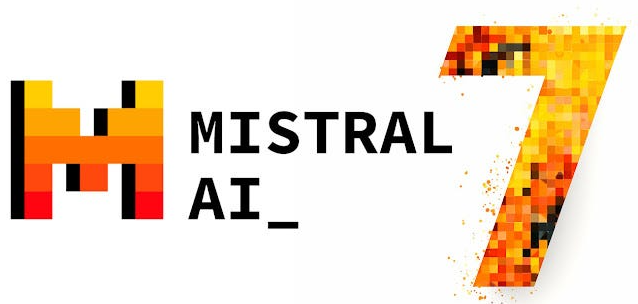

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
### Above is FIX for Unicode Error in Colab

01. How to run Mistral-7B-Instruct with Langchain and  BitsAndBytes
02. Simple RAG with Langchain / ChromaDB and  Mistral-7B-Instruct
03. Mistral-7B-Instruct with GGUF Format

In [ ]:
import shutil, os, subprocess


Mounted at /content/drive


**What is Bitsandbytes?**

The bitsandbytes is a lightweight wrapper around CUDA custom functions, in particular 8-bit optimizers, matrix multiplication (LLM.int8()), and quantization functions.

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U einops
!pip install -q -U safetensors
!pip install -q -U torch
!pip install -q -U xformers
!pip install -q -U langchain
!pip install -q -U ctransformers[cuda]
!pip install chromadb
!pip install sentence-transformers

01 : Running With LangChain

In [ ]:
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [ ]:
model_id = "mistralai/Mistral-7B-Instruct-v0.1"

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
model_4bit = AutoModelForCausalLM.from_pretrained( model_id, device_map="auto",quantization_config=quantization_config, )
tokenizer = AutoTokenizer.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
pipeline = pipeline(
        "text-generation",
        model=model_4bit,
        tokenizer=tokenizer,
        use_cache=True,
        device_map="auto",
        max_length=500,
        do_sample=True,
        top_k=5,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
)

In [ ]:
from langchain import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain
llm = HuggingFacePipeline(pipeline=pipeline)

In [ ]:
%%time
template = """<s>[INST] You are a helpful, respectful and honest assistant. Answer exactly in few words from the context
Answer the question below from context below :
{context}
{question} [/INST] </s>
"""

question_p = """What is the date for announcement"""
context_p = """ On August 10 said that its arm JSW Neo Energy has agreed to buy a portfolio of 1753 mega watt renewable energy generation capacity from Mytrah Energy India Pvt Ltd for Rs 10,530 crore."""
prompt = PromptTemplate(template=template, input_variables=["question","context"])
llm_chain = LLMChain(prompt=prompt, llm=llm)
response = llm_chain.run({"question":question_p,"context":context_p})
response

CPU times: user 2.37 s, sys: 138 ms, total: 2.51 s
Wall time: 4.99 s


'\nThe announcement was made on August 10.'

In [ ]:
%%time
template = """<s>[INST] You are a helpful, respectful and honest assistant. Answer exactly in few words from the context
Answer the question below from context below :
{context}
{question} [/INST] </s>
"""

question_p = """What company is buyer and seller here  """
context_p = """ On August 10 said that its arm JSW Neo Energy has agreed to buy a portfolio of 1753 mega watt renewable energy generation capacity from Mytrah Energy India Pvt Ltd for Rs 10,530 crore."""
prompt = PromptTemplate(template=template, input_variables=["question","context"])
llm_chain = LLMChain(prompt=prompt, llm=llm)
response = llm_chain.run({"question":question_p,"context":context_p})
response

CPU times: user 2.11 s, sys: 10.1 ms, total: 2.12 s
Wall time: 2.11 s


'\n* Company: JSW Neo Energy (buyer), Mytrah Energy India Pvt Ltd (seller)'

02 : RAG

In [ ]:
import chromadb
from chromadb.config import Settings
from langchain.llms import HuggingFacePipeline
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.vectorstores import Chroma

In [ ]:
mna_news = """JSW Energy on August 10 said that its arm JSW Neo Energy has agreed to buy a portfolio of 1753 mega watt renewable energy generation capacity from Mytrah Energy India Pvt Ltd for Rs 10,530 crore.
Sajjan Jindal led JSW group had signed an exclusivity agreement with Hyderabad based Mytrah Energy to buy the latter’s wind and solar assets.
This is the largest acquisition by JSW Energy since inception, which comprises 17 special purpose vehicles and 1 ancillary SPV.  The transaction is subject to approval of the Competition Commission of India (CCI) and other customary approvals standard to a transaction of this size, the company said in a release.
With this acquisition, JSW Energy's current  operational generation capacity will go up by over 35 percent from 4,784 MW to 6,537 MW.  Currently about 2,500 MW of under-construction wind and hydro projects which are likely to be commissioned in phases over the next 18-24 months, JSW Energy platform capacity gets enhanced to 9.1 GW – where the share of renewables increases to  65 percent, JSW said in a stock exchange filing. Further, this is likely to help the company in achieving its renewable-led capacity growth target of 10 GW by FY25, well ahead of timelines, the firm added.
"""

In [ ]:
from langchain.schema.document import Document
documents = [Document(page_content=mna_news, metadata={"source": "local"})]
#######################
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=20)
all_splits = text_splitter.split_documents(documents)
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "cuda"}
embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)
#######################
vectordb = Chroma.from_documents(documents=all_splits, embedding=embeddings, persist_directory="chroma_db")
#######################
retriever = vectordb.as_retriever()
#######################
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    verbose=True
)

def run_my_rag(qa, query):
    print(f"Query: {query}\n")
    result = qa.run(query)
    print("\nResult: ", result)

Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.


In [ ]:
query =""" What company is buyer and seller here """
run_my_rag(qa, query)

Query:  What company is buyer and seller here 



> Entering new RetrievalQA chain...

> Finished chain.

Result:    JSW Energy and Mytrah Energy


In [ ]:
query = """What is the total value of the deal?"""
run_my_rag(qa, query)

NameError: name 'run_my_rag' is not defined

In [ ]:
del pipeline
del llm
del model_4bit
del quantization_config
del tokenizer

03 : GGUF (Useful in CPU Only Inference)

In [ ]:
from langchain.llms import CTransformers
config = {'max_new_tokens': 100, 'temperature': 0}
llm = CTransformers(model='TheBloke/Mistral-7B-Instruct-v0.1-GGUF',model_file="mistral-7b-instruct-v0.1.Q4_K_M.gguf", config=config)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
%%time
template = """<s>[INST] You are a helpful, respectful and honest assistant. Answer exactly in few words from the context
Answer the question below from context below :
{context}
{question} [/INST] </s>
"""

question_p = """What is the date for announcement"""
context_p = """ On August 10 said that its arm JSW Neo Energy has agreed to buy a portfolio of 1753 mega watt renewable energy generation capacity from Mytrah Energy India Pvt Ltd for Rs 10,530 crore."""
prompt = PromptTemplate(template=template, input_variables=["question","context"])
llm_chain = LLMChain(prompt=prompt, llm=llm)
response = llm_chain.run({"question":question_p,"context":context_p})
response

CPU times: user 1min 23s, sys: 0 ns, total: 1min 23s
Wall time: 20.9 s


'The date for the announcement was August 10.'

In [ ]:
%%time
template = """<s>[INST] You are a helpful, respectful and honest assistant. Answer exactly in few words from the context
Answer the question below from context below :
{context}
{question} [/INST] </s>
"""

question_p = """What company is buyer and seller here  """
context_p = """ On August 10 said that its arm JSW Neo Energy has agreed to buy a portfolio of 1753 mega watt renewable energy generation capacity from Mytrah Energy India Pvt Ltd for Rs 10,530 crore."""
prompt = PromptTemplate(template=template, input_variables=["question","context"])
llm_chain = LLMChain(prompt=prompt, llm=llm)
response = llm_chain.run({"question":question_p,"context":context_p})
response

CPU times: user 34.2 s, sys: 0 ns, total: 34.2 s
Wall time: 8.59 s


'The buyer is JSW Neo Energy and the seller is Mytrah Energy India Pvt Ltd.'

In [ ]:
del config
del llm